## ALZHEIMER'S DETECTION USING MACHINE LEARNING MODEL
We explore the potential of machine learning in Alzheimer's disease detection. The model employs RandomForestClassifier and LocalOutlierFactor algorithms for this purpose. By leveraging these methods, the aim is to enhance the detection accuracy and timely intervention in Alzheimer's disease diagnosis.

In [246]:
# Import required packages
!pip install seaborn
!pip install scikit-learn --upgrade
!pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import tensorflow as tf


LOADING THE DATASET:
THE DATASET CONTAINS 373 ROWS WITH 14 COLUMNS WITH CLASSES DEMENTED AND NON-DEMENTED.

In [247]:
# Loading into a dataframe
df = pd.read_csv('oasis_longitudinal.csv')

# Have a peek at the data
# Returns fist 5 columns
print(df.head())

  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034  


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


#PREPROCESSING THE DATA
DROPPING IRRELEVANT COLUMNS

In [249]:
# Dropping the list of columns mentioned
df = df.drop(['Subject ID', 'MRI ID', 'Hand', 'Visit', 'MR Delay'], axis=1)
df.shape

(373, 10)

In [250]:
df['Group'].value_counts()

,count
Group,
Nondemented,190
Demented,146
Converted,37


In [251]:
df['M/F'] = df['M/F'].replace(['F', 'M'], [0, 1])
df['Group'] = df['Group'].replace(['Converted', 'Demented', 'Nondemented'], [2, 1, 0])
df['Group'] = df['Group'].replace({2: 1, 1: 1, 0: 0})

<ipython-input-251-dd947324fa4e>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['M/F'] = df['M/F'].replace(['F', 'M'], [0, 1])
<ipython-input-251-dd947324fa4e>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Group'] = df['Group'].replace(['Converted', 'Demented', 'Nondemented'], [2, 1, 0])


In [252]:
df.isnull().sum()

,0
Group,0
M/F,0
Age,0
EDUC,0
SES,19
MMSE,2
CDR,0
eTIV,0
nWBV,0
ASF,0


In [253]:
# Fill with mode values
df['SES'] = df['SES'].fillna(value= df['SES'].mode().iloc[0])
# Fill with mean values
df['MMSE'] = df['MMSE'].fillna(value =df['MMSE'].median())

In [254]:
Y = df['Group'].values
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']]

Y represents the target variable – labels as a Numpy array and X represents the list of selected columns as a matrix which is used for the classification task.

In [255]:
numerical_features = ['Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF']
categorical_features = ['M/F', 'SES']

#Treating Outliers
The contamination parameter is set to 0.05, which means we're expecting 5% outliers in the data. The LOF (Local Outliers Factor) algorithm computes a score for each sample. Samples with a score lower than -1 are considered outliers, while samples with a score greater than or equal to -1 are considered inliers.


This approach helps identify and handle outliers in the dataset, which is important for improving the robustness and accuracy of machine learning models.

In [256]:
def remove_outliers(X, Y, contamination=0.05):
    lof = LocalOutlierFactor(contamination=contamination, novelty=False)
    y_pred = lof.fit_predict(X)
    X_filtered = X[y_pred != -1]
    Y_filtered = Y[y_pred != -1]
    print(f"Removed {len(X) - len(X_filtered)} outliers")
    return X_filtered, Y_filtered

X_filtered, Y_filtered = remove_outliers(X, Y)

Removed 19 outliers


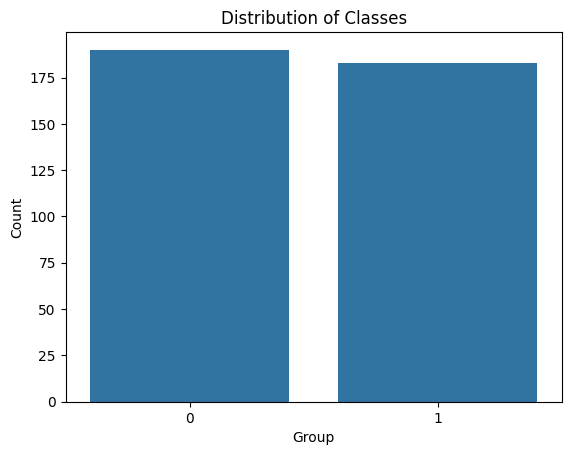

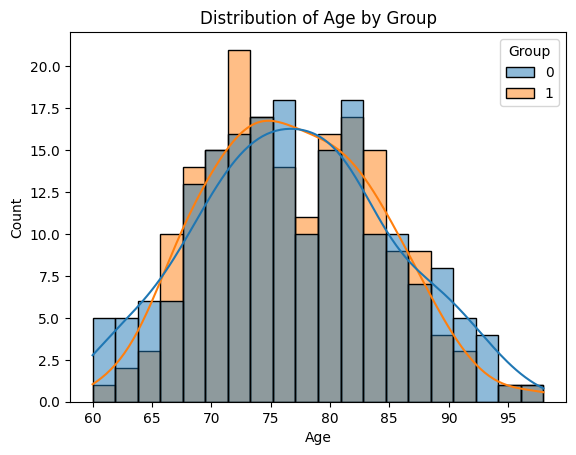

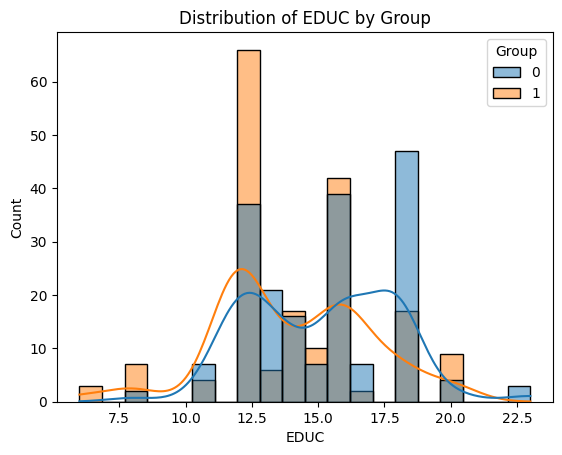

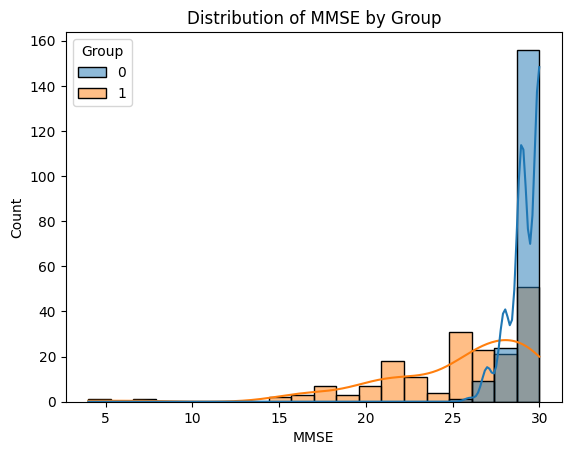

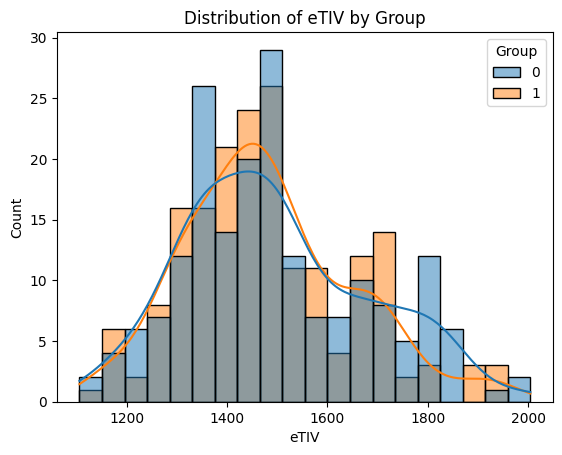

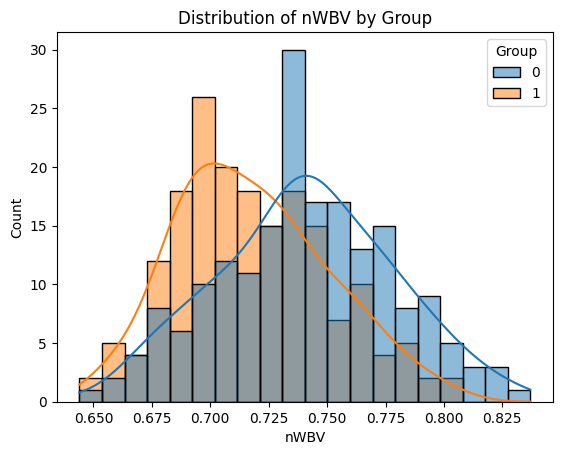

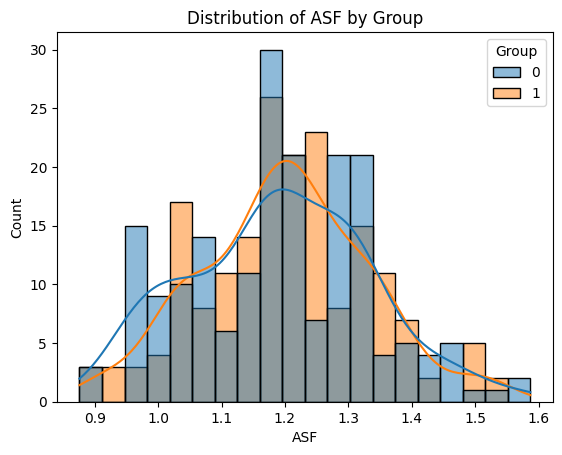

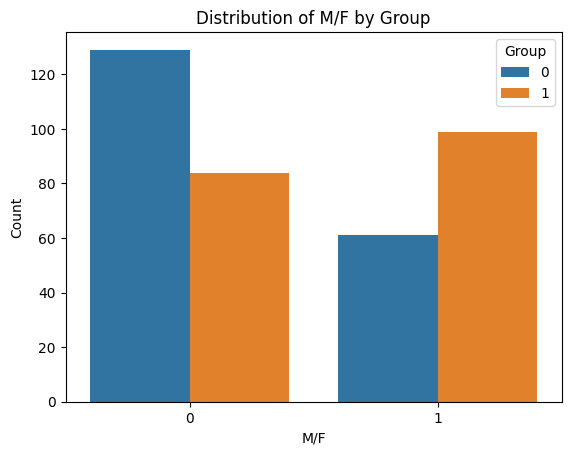

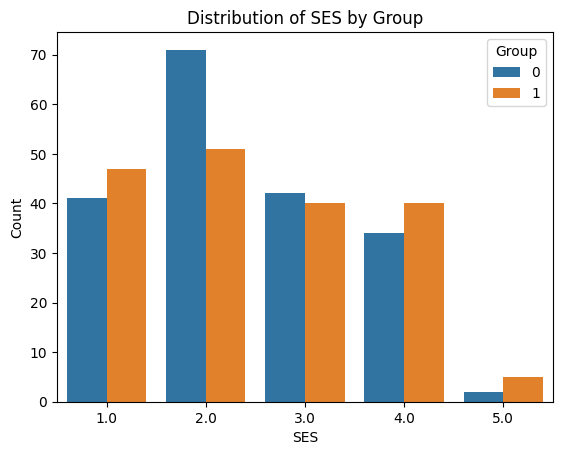

In [257]:
def plot_distributions(df, numerical_features, categorical_features):
    # Class distribution
    sns.countplot(data=df, x='Group')
    plt.title("Distribution of Classes")
    plt.xlabel("Group")
    plt.ylabel("Count")
    plt.show()

    # Numerical features
    for feature in numerical_features:
        sns.histplot(data=df, x=feature, hue='Group', kde=True, bins=20)
        plt.title(f"Distribution of {feature} by Group")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.show()

    # Categorical features
    for feature in categorical_features:
        sns.countplot(data=df, x=feature, hue='Group')
        plt.title(f"Distribution of {feature} by Group")
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.show()

numerical_features = ['Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF']
categorical_features = ['M/F', 'SES']
plot_distributions(df, numerical_features, categorical_features)


# Standardize and One Hot Encoding
The next two steps represent that we are selecting only inliers for further processing. This step of code creates transformers for categorical numerical and numerical features and helps in training the model consistently.

MinMaxScalar helps to scale numerical features.
OneHotEncoder is used to encode categorical features.
These transformers are merged using a ColumnTransformer.

In [258]:
#numerical transformer and categorical transformer
numerical = MinMaxScaler()
categorical = OneHotEncoder(drop='first')

p = ColumnTransformer(transformers=[('num', numerical, numerical_features),
									('cat', categorical, categorical_features)])

Group: Nondemented or Demented

EDUC: Years of education

SES: Socioeconomic Status

MMSE: Mini-Mental State Examination

CDR: Clinical Dementia Rating

eTIV: Estimated Total Intracranial Volume

nWBV: Normalize Whole Brain Volume

ASF: Atlas Scaling Factor

# Splitting data for training and testing

In [259]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_filtered, Y_filtered, test_size=0.3, random_state=42, stratify=Y_filtered)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

 It splits the dataset into training and testing sets with a default ratio of 70% for training data and 15% for testing data and validation.

 This default split is a commonly used practice in machine learning to ensure a good balance between the amount of data used for training and the amount used for testing.

# Build the Pipeline
We are making a pipeline to streamline the machine learning workflow by combining preprocessing steps and model training into a single entity. By using a pipeline, we can simplify the workflow, ensuring that the preprocessing steps are consistently applied to both the training and testing data, and making it easier to deploy the model in production.

In [260]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Traditional Machine Learning Models
def train_evaluate_ml_models(X_train, Y_train, X_val, Y_val):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'SVM': SVC(probability=True, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }

    best_model = None
    best_score = 0

    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        print(f"\nTraining {name}...")
        pipeline.fit(X_train, Y_train)

        # Evaluate on validation set
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else pipeline.decision_function(X_val)

        # Calculate metrics
        accuracy = accuracy_score(Y_val, y_pred)
        precision = precision_score(Y_val, y_pred)
        recall = recall_score(Y_val, y_pred)
        f1 = f1_score(Y_val, y_pred)
        roc_auc = roc_auc_score(Y_val, y_proba)

        print(f"{name} Validation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(classification_report(Y_val, y_pred))

        # Check if this is the best model
        if roc_auc > best_score:
            best_score = roc_auc
            best_model = pipeline

    return best_model

best_ml_model = train_evaluate_ml_models(X_train, Y_train, X_val, Y_val)


Training Random Forest...
Random Forest Validation Metrics:
Accuracy: 0.9057
Precision: 0.8889
Recall: 0.9231
F1-Score: 0.9057
ROC-AUC: 0.9509
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        27
           1       0.89      0.92      0.91        26

    accuracy                           0.91        53
   macro avg       0.91      0.91      0.91        53
weighted avg       0.91      0.91      0.91        53


Training XGBoost...
XGBoost Validation Metrics:
Accuracy: 0.8302
Precision: 0.8148
Recall: 0.8462
F1-Score: 0.8302
ROC-AUC: 0.9217
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        27
           1       0.81      0.85      0.83        26

    accuracy                           0.83        53
   macro avg       0.83      0.83      0.83        53
weighted avg       0.83      0.83      0.83        53


Training SVM...
SVM Validation Metrics:
Accuracy: 0.8868
Precision: 0

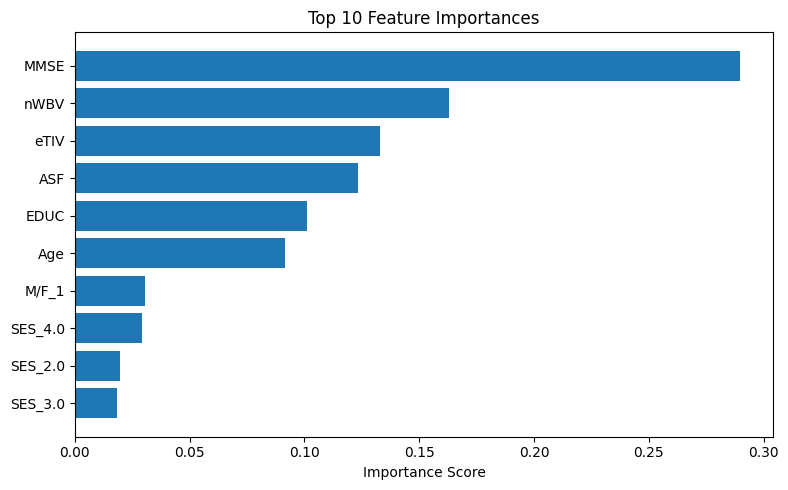

In [261]:
def plot_feature_importances(pipeline, feature_names):
    model = pipeline.named_steps['classifier']

    if hasattr(model, 'feature_importances_'):
        # Get feature names after preprocessing
        preprocessor = pipeline.named_steps['preprocessor']
        ohe_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        all_features = list(preprocessor.named_transformers_['num'].feature_names_in_) + list(ohe_features)

        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10

        plt.figure(figsize=(8, 5))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [all_features[i] for i in indices])
        plt.title("Top 10 Feature Importances")
        plt.xlabel("Importance Score")
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not support feature importances.")

plot_feature_importances(best_ml_model, numerical_features + categorical_features)

In [262]:
preprocessor.fit(X_train)
X_train_scaled = preprocessor.transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

In [281]:
from tensorflow.keras.regularizers import l2
def build_ann_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')  # For binary classification
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

In [289]:
nn_model = build_ann_model(X_train_ann.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Change ann_model to nn_model in the fit method call
history = nn_model.fit(
    X_train_ann, Y_train,
    validation_data=(X_val_ann, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5981 - auc_12: 0.6415 - loss: 0.8926 - val_accuracy: 0.6981 - val_auc_12: 0.7450 - val_loss: 0.7426
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5863 - auc_12: 0.6675 - loss: 0.8223 - val_accuracy: 0.6981 - val_auc_12: 0.7813 - val_loss: 0.7248
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6541 - auc_12: 0.7162 - loss: 0.7985 - val_accuracy: 0.7170 - val_auc_12: 0.8048 - val_loss: 0.7094
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6498 - auc_12: 0.6923 - loss: 0.7938 - val_accuracy: 0.7170 - val_auc_12: 0.8184 - val_loss: 0.6950
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7287 - auc_12: 0.8209 - loss: 0.6349 - val_accuracy: 0.7358 - val_auc_12: 0.8276 - val_loss: 0.6801
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6697 - auc_12: 0.7608 - loss: 0.7303 - val_accuracy: 0.7925 - val_auc_12: 0.8476 - val_loss: 0.6668
Epoch 7/100
8/8 

# Predictions

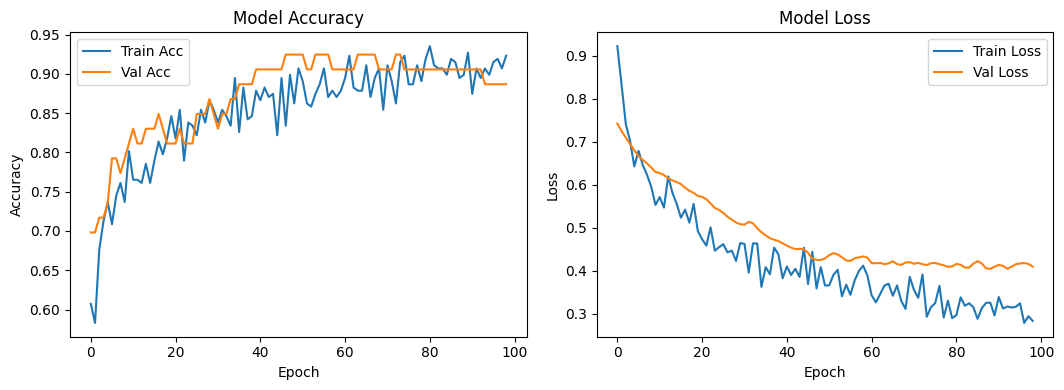

In [291]:
# Accuracy
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


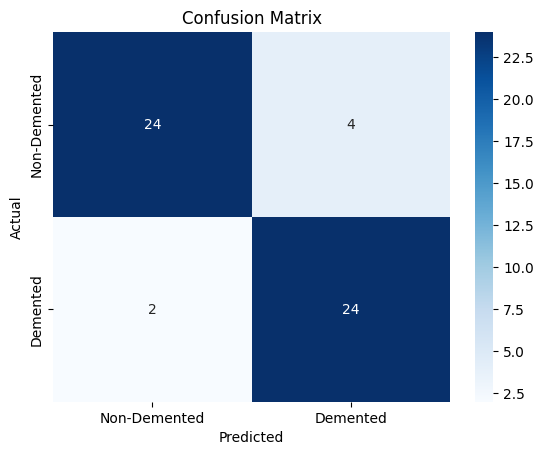

In [292]:
# Predict probabilities and convert to binary class labels
y_pred_prob = nn_model.predict(X_test_ann)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Demented', 'Demented'], yticklabels=['Non-Demented', 'Demented'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

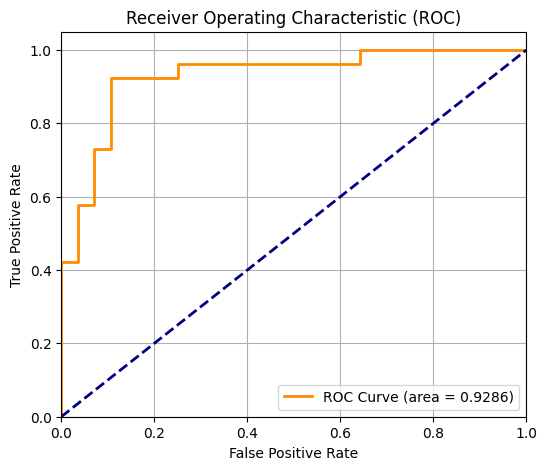

In [293]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Evaluating the model

In [295]:
# Assuming 'best_ml_model' and 'X_test', 'Y_test' are defined from the previous code
y_pred = best_ml_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy of the best ML model on the test set: {accuracy}")

# For the ANN model:
from sklearn.metrics import accuracy_score

y_pred_ann = nn_model.predict(X_test_ann)
y_pred_ann = (y_pred_ann > 0.5).astype(int) # Convert probabilities to class labels
accuracy_ann = accuracy_score(Y_test, y_pred_ann)
print(f"Accuracy of the ANN model on the test set: {accuracy_ann}")

Accuracy of the best ML model on the test set: 0.8518518518518519
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy of the ANN model on the test set: 0.8888888888888888


In [297]:
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print("ANN Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

ANN Evaluation Metrics:
Accuracy: 0.8519
Precision: 0.8750
Recall: 0.8077
F1 Score: 0.8400
ROC AUC: 0.9286

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        28
           1       0.88      0.81      0.84        26

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54

